In [114]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy

import jastrowspin
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [115]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def H2_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccecpccpvqz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 3,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [79]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
mol, mf, mcc = H2_casci(scf_checkfile, ci_checkfile)
# mol, mf, mcc = HF_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


In [116]:
from wftools import generate_jastrow
jastrow, to_opt = generate_jastrow(mol)

In [99]:
configs = mc.fixed_initial_guess(mol, nconfig)
x = configs.configs[:,0][:,2] # fixed electron is 1, z coordinate

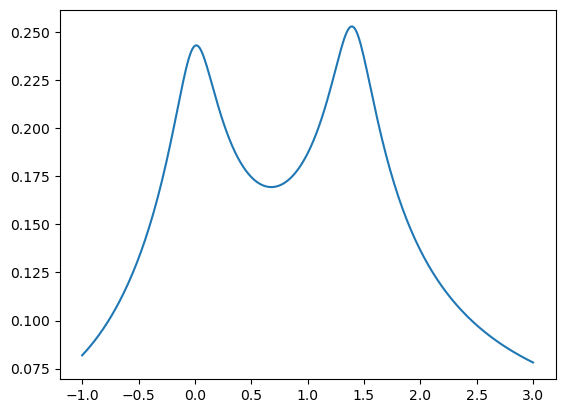

In [100]:
s, v = jastrow.recompute(configs)
plt.plot(x, v)

In [110]:
e = 0
g, _, _ = jastrow.gradient_value(e, configs.electron(e))
g_num = np.gradient(v, x) 

In [111]:
g.shape

(3, 323)

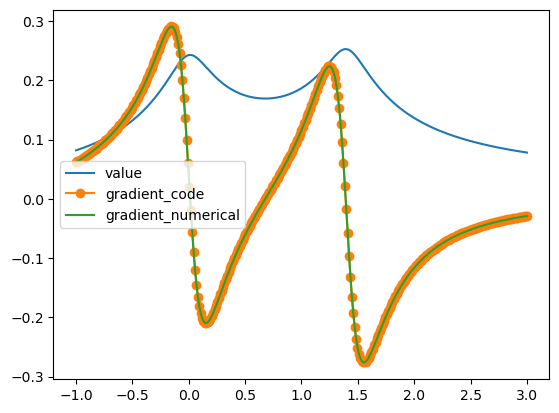

In [118]:
# plt.plot(x, v)
plt.plot(x, v, label='value')
plt.plot(x, g[2], '-o', label='gradient_code')
plt.plot(x, g_num, label='gradient_numerical')
plt.legend()